### Compare Campaign Measurements

#### Define measurement query and which measurement quantities to plot

##### Available Measurement Quantities
Ambient, Coolant, I_d, I_q, Motor_speed, Pm, Stator_tooth, Stator_winding, Stator_yoke, Time, Torque, U_d, U_q

In [2]:
mea_result_conditions = {
                "Name": {"$like": "Profile_*"},
                "TestStep.Test.Name": {"$in": ["Campaign_03", "Campaign_04"]},
                "TestStep.Test.StructureLevel.Project.Name": {"$eq": "ElectricMotorTemperature"}
            }

mq_names = ["Motor_speed", "Torque"]

#### Retrieve content from ASAM ODS ODS service

In [3]:
from odsbox import ConI

with ConI(url="https://docker.peak-solution.de:10032/api", auth=("Demo", "mdm")) as con_i:
    # Query measurements to compare
    measurements = con_i.query_data({
            "MeaResult": mea_result_conditions,
            "$attributes": {
                "Name": 1,
                "Id": 1,
                "TestStep": {
                    "Name": 1,
                    "Test": {
                        "Name": 1,
                        "StructureLevel": {
                            "Name": 1,
                            "Project": {
                                "Name": 1
                                }}}},
            },
        })
    measurement_ids = measurements["MeaResult.Id"].tolist()

    # Query submatrices of measurements containing the specified measurement quantities
    submatrices = con_i.query({
            "AoSubMatrix": {
                "measurement": {"$in": measurement_ids},
                "local_columns": {
                    "name": {
                        "$in": mq_names
                    },
                }
            },
            "$attributes": {
                "id": 1,
                "number_of_rows": 1,
                "measurement": 1,
            },
            "$groupby": {
                "id": 1,
                "measurement": 1,
                "number_of_rows": 1,
            }
        })
    submatrix_ids = submatrices["id"].tolist()
    # Get units and other info of local columns in submatrices
    local_columns = con_i.query(
        {
            "AoLocalColumn": {
                "submatrix": {"$in": submatrix_ids},
                "$or": [
                    {"name": {"$in": mq_names}},
                    {"independent": 1}
                ]
            },
            "$attributes": {
                "id": 1,
                "name": 1,
                "independent": 1,
                "measurement_quantity.unit:OUTER.name": 1,
            }
        })
    local_column_ids = local_columns["id"].tolist()
    # Fetch bulk data for local columns
    local_columns_signals = con_i.bulk.query({"id":{"$in": local_column_ids}})

#### Prepare collected data for plotting

In [4]:
import pandas as pd

# lookup for units of local columns
local_column_unit_lookup = dict({row["id"]: row["measurement_quantity.unit:OUTER.name"]
                                 for _, row in local_columns.iterrows()})

# generate title for each submatrix
submatrix_title_lookup = {}
for submatrix_id in submatrix_ids:
    measurement_id = submatrices[submatrices['id'] == submatrix_id]['measurement'].values[0]
    measurement_info = measurements[measurements['MeaResult.Id'] == measurement_id]
    if not measurement_info.empty:
        project = measurement_info['Project.Name'].values[0]
        profile = measurement_info['MeaResult.Name'].values[0]
        campaign = measurement_info['Test.Name'].values[0]
        submatrix_title_lookup[submatrix_id] = f"{project} - {campaign} - {profile}"
    else:
        submatrix_title_lookup[submatrix_id] = f"Submatrix {submatrix_id}"

# Create dataframes for each measurement to compare
measurement_data_items = []
for submatrix_id, df in local_columns_signals.groupby("submatrix"):
    # Create dataframe using name as column names and values as column data
    data_dict = {row['name']: row['values'] for _, row in df.iterrows()}
    sub_df = pd.DataFrame(data_dict)
    if not all(col in sub_df.columns for col in mq_names):
        print(f"Skipping submatrix {submatrix_id} as it lacks required columns.")
        continue

    independent_rows = df[df['independent'] == 1]
    independent_name = "Index"
    independent_unit = "-"
    # Set the independent column as the index
    if not independent_rows.empty:
        independent_name = independent_rows['name'].iloc[0]
        sub_df.set_index(independent_name, inplace=True)
        independent_unit = local_column_unit_lookup.get(independent_rows['id'].iloc[0], '-')
    # create axis labels from name and unit
    label_dict = {name: f"{name} [{local_column_unit_lookup.get(id, '-')}]"
                  for name, id in zip(df['name'], df['id'])}
    # information to be plotted
    measurement_data_items.append({
        "title": f"{submatrix_title_lookup.get(submatrix_id, 'Unknown')} \n(Color: {independent_name} [{independent_unit}])",
        "data": sub_df,
        "labels": label_dict })

# Sort measurement_data_items by title (moved outside the loop)
measurement_data_items.sort(key=lambda x: x["title"])

#### Plot measurements

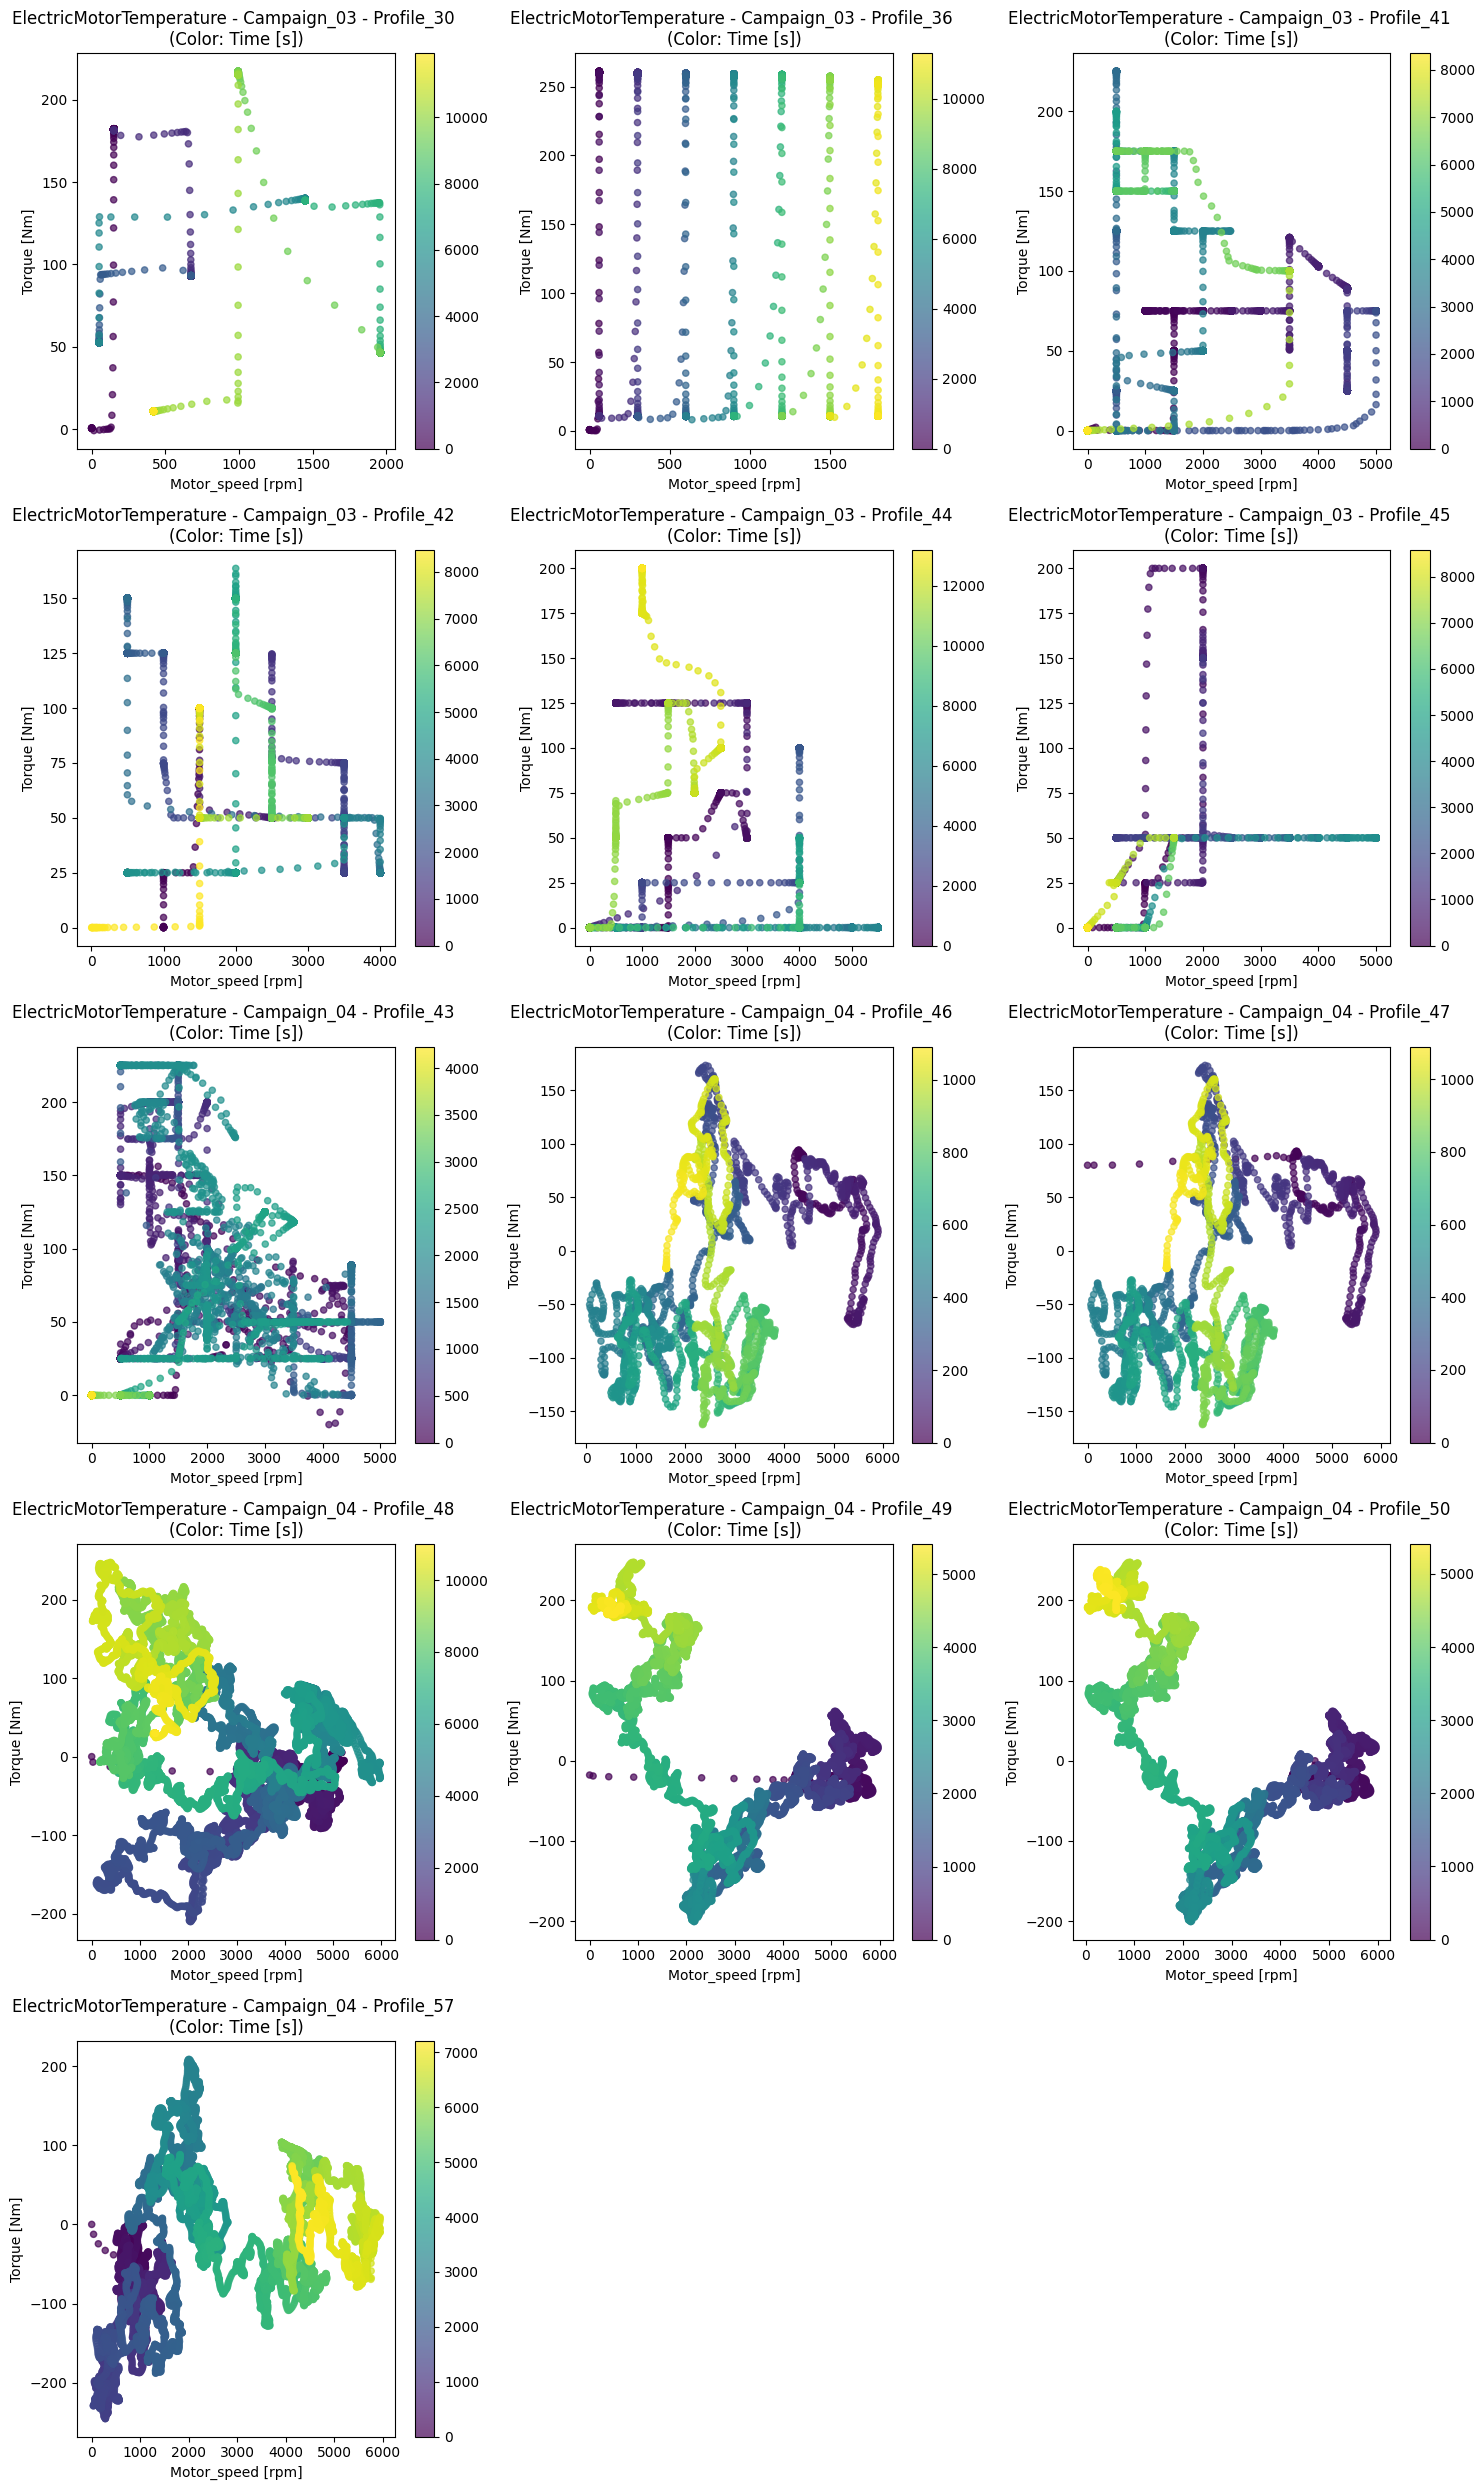

In [5]:
import matplotlib.pyplot as plt

# Number of submatrices
num_of_plots = len(measurement_data_items)

# Calculate number of rows (3 submatrices per row)
cols = 3
rows = (num_of_plots + cols - 1) // cols  # Ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i, measurement_data in enumerate(measurement_data_items):
    ax = axes[i]
    measurement_data["data"].plot.scatter(
        x=mq_names[0],
        y=mq_names[1],
        c=measurement_data["data"].index,
        colormap="viridis",
        ax=ax,
        alpha=0.7,
        s=20
    )
    ax.set_xlabel(measurement_data["labels"].get(mq_names[0], mq_names[0]))
    ax.set_ylabel(measurement_data["labels"].get(mq_names[1], mq_names[1]))
    ax.set_title(measurement_data["title"])

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()